In [2]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import camelot
import pickle
from IPython.display import clear_output
import seaborn as sns

ModuleNotFoundError: No module named 'bs4'

In [3]:
def extract_data():
    r = requests.get(
        "https://www.massport.com/logan-airport/about-logan/noise-abatement/complaints-by-townss/",
        headers={"user-agent": "parser/0.0.1"},
    )
    soup = BeautifulSoup(r.content, "html.parser")
    dfs = []
    base_url = "https://www.massport.com"

    total_to_process = len(soup.select("table a"))
    processed = 0

    tables = soup.find_all("table")
    for table in tables:
        year = table.find(string=re.compile(".*Noise Complaint Reports by Towns"))[0:4]
        links = table.find_all("a")
        for link in links:
            month = link.text.strip()
            link = base_url + link["href"]
            df = camelot.read_pdf(link, flavor="stream", strip_text=",")[0].df

            # delete the total row at the bottom
            df = df[~df[0].isin(["Totals:", "Communities:", "Communities", "Totals"])]

            if (df[0] == "Community").any():
                # make the first row with the word "Community" the header
                # and delete it and everything above it
                header_row_index = df[0].eq("Community").idxmax()
                df.columns = df.iloc[header_row_index].values
                df = df[header_row_index + 1:]
            else:
                print(f"Can't set head for {processed}: {link} because it doesn't have a Community column")
                print(df.head())

            df["date"] = pd.to_datetime(f"{year} {month}")
            df["link"] = link
            df.rename(columns={"Calls": "Complaints", "Callers": "Complainants"}, inplace=True)

            dfs.append(df)
            processed += 1

    # these two had parsing errors. need to look into this further
    dfs[39].columns = ["Community", "Complaints", "Addresses", "Residents", "date", "link"]
    dfs[40].columns = ["Community", "Complaints", "Residents", "date", "link"]

    # this is a yearly summary included by mistake https://www.massport.com/media/1297/2013_monthlycomplaintswebapril.pdf
    del dfs[110]
    del dfs[109]

    return dfs

data = extract_data()
file = open("data.pkl", "wb")
pickle.dump(data, file)

Can't set head for 39: https://www.massport.com/media/3135/march-2019-complaints-for-website.pdf because it doesn't have a Community column
             0    1   2   3
0    Cambridge  228  30  33
1  Charlestown    8   4   4
2   Chelmsford  595   1   1
3      Chelsea  795   6   7
4     Cohasset  107   2   2
Can't set head for 40: https://www.massport.com/media/3214/april-2019-complaints-for-website.pdf because it doesn't have a Community column
             0    1   2
0       Boston  282   3
1    Cambridge  332  42
2  Charlestown    2   1
3   Chelmsford  227   1
4      Chelsea  709   6


In [8]:
all_data = pd.concat(data[:109])
all_data["Complainants"] = pd.to_numeric(all_data["Complainants"])
all_data["Complaints"] = pd.to_numeric(all_data["Complaints"])
all_data["Addresses"] = pd.to_numeric(all_data["Addresses"])
all_data["Residents"] = pd.to_numeric(all_data["Residents"])
all_data["Households"] = pd.to_numeric(all_data["Households"])

all_data[["Community", "Complaints", "date", "link"]].to_csv("data.csv", index=False)
all_data

,Community,Complaints,Complainants,Addresses,date,link,Residents,Households
3,Arlington,1498.0,16.0,15.0,2023-01-01,https://www.massport.com/media/gbthvmpm/januar...,NaN,NaN
4,Ayer,4.0,1.0,1.0,2023-01-01,https://www.massport.com/media/gbthvmpm/januar...,NaN,NaN
5,Belmont,56.0,8.0,8.0,2023-01-01,https://www.massport.com/media/gbthvmpm/januar...,NaN,NaN
6,Boston,8.0,4.0,4.0,2023-01-01,https://www.massport.com/media/gbthvmpm/januar...,NaN,NaN
7,Braintree,296.0,1.0,1.0,2023-01-01,https://www.massport.com/media/gbthvmpm/januar...,NaN,NaN
...,...,...,...,...,...,...,...,...
38,West Roxbury,9.0,3.0,NaN,2014-12-01,https://www.massport.com/media/1306/2014_month...,NaN,NaN
39,Weston,1.0,1.0,NaN,2014-12-01,https://www.massport.com/media/1306/2014_month...,NaN,NaN
40,Weymouth,6.0,1.0,NaN,2014-12-01,https://www.massport.com/media/1306/2014_month...,NaN,NaN
41,Winchester,16.0,5.0,NaN,2014-12-01,https://www.massport.com/media/1306/2014_month...,NaN,NaN


[Text(0.5, 1.0, 'Airplane noise complaints in Somerville')]

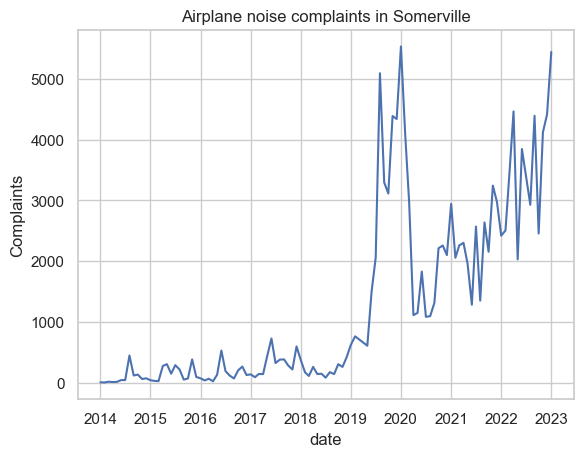

In [369]:
sns.set_theme(style="whitegrid")
sns.lineplot(
    data=all_data[all_data["Community"] == "Somerville"], x="date", y="Complaints"
).set(title="Airplane noise complaints in Somerville")